In [1]:
import os
experiment_name = "WFV1_unet"
# Download val folder
path_to_dataset_folder = '.'
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
val_folder = os.path.join(dataset_folder, "val")

folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)

if not os.path.exists(folder_name_model_weights):
    import gdown
    gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                          output=folder_name_model_weights)

if not os.path.exists(val_folder):
    import gdown
    os.makedirs(val_folder, exist_ok=True)
    # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
    gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                          output=val_folder)

## Step 1: Get config

In [2]:
from ml4floods.models.config_setup import get_default_config

config_fp = os.path.join(folder_name_model_weights, "config.json")

config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
config["model_params"]["max_tile_size"] = 128

Loaded Config for experiment:  training_flooding_bgri
{   'data_params': {   'batch_size': 96,
                       'bucket_id': '',
                       'channel_configuration': 'bgri',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 24,
                       'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split_local.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

## Step 2: Load pre-trained model

In [3]:
from ml4floods.models.model_setup import get_model

model_folder = os.path.dirname(folder_name_model_weights)
if model_folder == "":
    model_folder = "."

config["model_params"]['model_folder'] = model_folder
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

/home/trongan93/pt-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded model weights: ./WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

In [4]:
from ml4floods.models.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True)

Getting model inference function


## Step 3: Run Inference

bgri
torch_input shape:  torch.Size([4, 3918, 9554])
transform shape:  | 0.00, 0.00, 15.43|
| 0.00,-0.00, 60.69|
| 0.00, 0.00, 1.00|


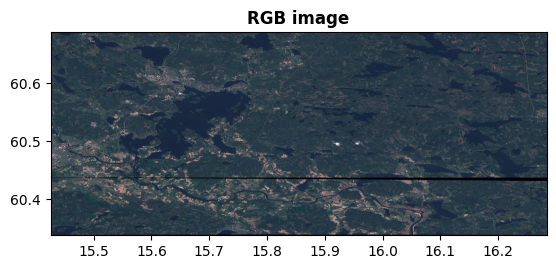

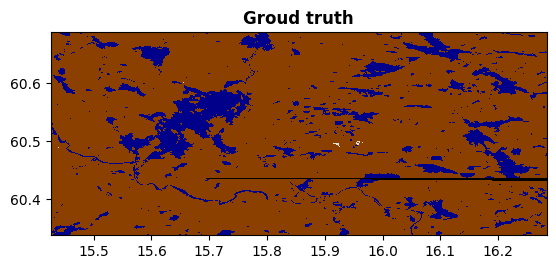

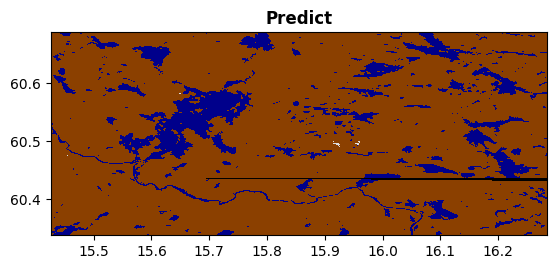

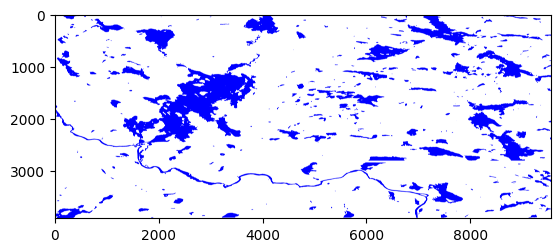

In [5]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration
print(channel_configuration)

# dataset_folder = gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/
event_id_file_img = "EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.tif"
event_id_file_map = "EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.geojson"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id_file_img)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id_file_img)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id_file_img)
flood_map = os.path.join(dataset_folder, "val", "floodmaps", event_id_file_map)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
print('torch_input shape: ', torch_inputs.shape)
print('transform shape: ', transform)

# Make predictions
outputs = inference_function(torch_inputs.unsqueeze(0))[0] # (num_classes, h, w)
prediction = torch.argmax(outputs, dim=0).long() # (h, w)

# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])

# New Plot 
plot_utils.plot_rgb_image(torch_inputs, transform=transform,channel_configuration=channel_configuration, title = "RGB image")
plot_utils.plot_gt_v1(torch_targets, transform=transform, title = "Groud truth")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, title = "Predict")
plot_utils.plot_gt_v1_wateronly(prediction.unsqueeze(0),transform=transform)


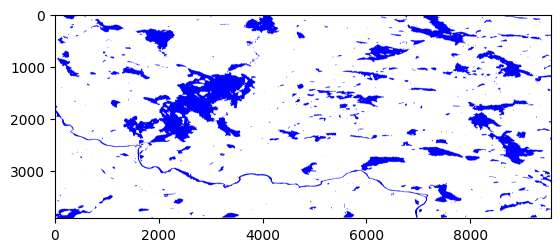

In [6]:
plot_utils.plot_permanent(torch_permanent_water, transform=transform, channel_configuration=channel_configuration)

target shape:  (3918, 9554)
target count:  4791615
permanent shape:  (3918, 9554)
permanent count:  4440170
flood_map count:  488304


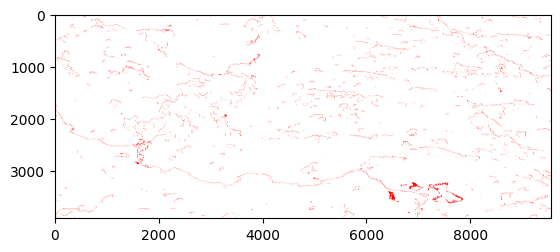

In [7]:
plot_utils.plot_flood(prediction.unsqueeze(0),torch_permanent_water,transform=transform)